# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA
from hnc.hnc.PIE_TwoElectron import Plasma_of_Ions_and_Electrons as PLASMA_UD

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

from pandas import read_csv

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


ModuleNotFoundError: No module named 'mendeleev'


# Function that sets up HNC QSP 

## Load TCCW Cases

In [2]:
element='Be2'

if element=='Be1':
    ni_cc = 1.24e23
    Te_eV = 12
    Ti_eV = Te_eV
    Z, A = 4, 9
    Zbar = 2.105
elif element=='Be2':
    ni_cc = 3.67e23
    Te_eV = 13
    Ti_eV = Te_eV
    Z, A = 4, 9
    # Zbar = 2.21
    Zbar = 2
elif element=='Be3':
    ni_cc = 3.67e23
    Te_eV = 2
    Ti_eV = Te_eV
    Z, A = 4, 9
    Zbar = 2.21
# elif element='Al1':
#     ni_cc = 6.03e22
#     Te_eV = 1
#     Ti_eV = 1
#     Z, A= 13,
    

ni_AU = ni_cc*1e6*aB**3

r_s_AU = rs_from_n(ni_AU)
r_c = 0
if r_c>1:
    r_c=1e-5
print("Te = {0:.3e} eV, n_i = {1:.3e} 1/cc".format(Te_eV, ni_cc))
print("Te = {0:.3e} K, ρ = {1:.3e} [g/cc] ".format(Te_eV*eV_to_K, 1e3*ni_cc*m_p*A ))
print("r_s = {0:.3f}, r_c/r_s = {1:.3f}".format(r_s_AU, r_c))

Te = 1.300e+01 eV, n_i = 3.670e+23 1/cc
Te = 1.509e+05 K, ρ = 6.055e+30 [g/cc] 
r_s = 1.637, r_c/r_s = 0.000


In [3]:
atom = PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=True,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options= {'r_c':0.0},
             hnc_options= {'kappa_multiscale':10, 'R_max':5,'N_bins':500,'oz_method':'svt'},
             hnc_solve_options={'alpha_Picard':0.1})


Te_in_eV: 13.000
Ti_in_eV: 13.000


(0.0, 3.887454708500331)

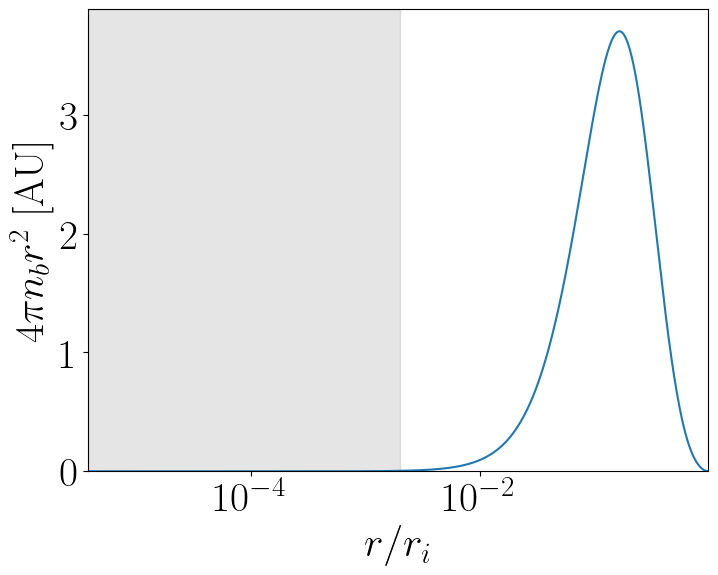

In [4]:
bound_file = "/home/zach/plasma/hnc/TCCW/data/Be_rs_1.637_T_1.300e+01eV.csv"
AA_data = read_csv(bound_file, delim_whitespace=True, header=0)
AA_r_AU_full = np.array(AA_data['r[a_0]'])
AA_nb_AU_full = np.array(AA_data['n(bound)'])

# Only use some values for speed
min_r_to_use = 0.2*atom.hnc.r_array[0]*atom.qsp.ri # in AU
indcs = np.where(AA_r_AU_full > min_r_to_use)
AA_r_AU = AA_r_AU_full[indcs]
AA_nb_AU = AA_nb_AU_full[indcs]

# Plot bound states
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(AA_r_AU_full/atom.qsp.ri, 4*π*AA_nb_AU_full*AA_r_AU_full**2)
ax.axvspan(AA_r_AU_full[0]/atom.qsp.ri, min_r_to_use/atom.qsp.ri, color='k', alpha=0.1)
ax.set_xlabel(r'$r/r_i$')
ax.set_ylabel(r'$4 \pi n_b r^2$ [AU]')
ax.set_xscale('log')
ax.set_xlim(np.min(AA_r_AU_full/atom.qsp.ri), np.max(AA_r_AU_full/atom.qsp.ri))
ax.set_ylim(0, None)

[-1, 1, 0.002023572153014456, 0.999772922333556]


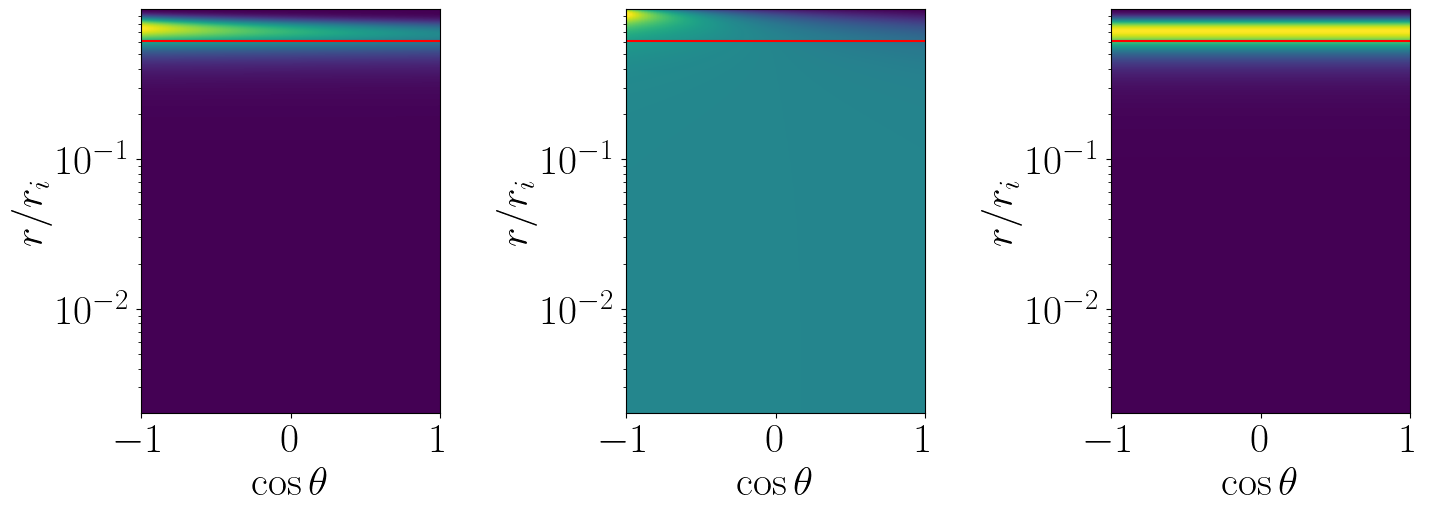

0.6837182835085135

In [5]:
from scipy.integrate import dblquad, simpson
from scipy.interpolate import RegularGridInterpolator

def new_δβuei(r_sep_in_AU, verbose = False, only_Pauli=True):
    r_array = AA_r_AU #AU
    rs = atom.qsp.ri
    cosφ_array = np.linspace(-1,1,num=100)
    r_mesh, cosφ_mesh = np.meshgrid(r_array,cosφ_array, indexing='ij')

    nb_mesh = AA_nb_AU[:,np.newaxis] * np.ones_like(r_mesh)
    ree_mesh = np.sqrt( r_sep_in_AU**2 + r_mesh**2 + 2*r_mesh*r_sep_in_AU*cosφ_mesh  )
    
    if only_Pauli:
        # βu_ee_mesh = atom.qsp.βv_Pauli(ree_mesh/rs, atom.qsp.Λee)
        βu_ee_mesh = atom.βP_ee_func(ree_mesh/rs)
    else:
        βu_ee_mesh = atom.qsp.βvee( ree_mesh/rs  ) + atom.βP_ee_func(ree_mesh/rs) - atom.qsp.βv_Pauli(ree_mesh/rs, atom.qsp.Λee)
    
    integrand_mesh = 2*π* r_mesh**2 * nb_mesh*βu_ee_mesh
    
    if verbose:
        fig, axs = plt.subplots(1,3)
        extent = [-1,1, r_array[0]/atom.qsp.ri, r_array[-1]/atom.qsp.ri]
        print(extent)
        axs[0].imshow(r_mesh**2 * nb_mesh*βu_ee_mesh, origin='lower', extent=extent)
        axs[1].imshow(βu_ee_mesh, origin='lower', extent=extent)
        axs[2].imshow(r_mesh**2 * nb_mesh, origin='lower', extent=extent)
        for ax in axs:
            ax.set_ylabel(r'$r/r_i$')
            ax.set_xlabel(r'$\cos \theta$')
            ax.set_yscale('log')
            ax.plot(cosφ_array, np.ones_like(cosφ_array) * r_sep_in_AU/atom.qsp.ri ,'r')

        plt.tight_layout()
        plt.show()
    δβuei_simpson = simpson(simpson(integrand_mesh, axis=0, x=r_array), axis=0, x=cosφ_array)
    
#     δβuei_interp = RegularGridInterpolator( (r_array, cosφ_array), integrand_mesh  )
#     δβuei_integrand = lambda y, x : δβuei_interp((x, y)) # Weird convention, flipping not a mistake...
#     δβuei = dblquad(δβuei_integrand, r_array[0], r_array[-1], -1, 1)
    
    return δβuei_simpson#, δβuei
    
new_δβuei(1, verbose=True)

In [6]:
δβuei = np.array([new_δβuei(r_hnc*atom.qsp.ri, only_Pauli=False) for r_hnc in atom.hnc.r_array])
δβuei_Pauli = np.array([new_δβuei(r_hnc*atom.qsp.ri) for r_hnc in atom.hnc.r_array])

(-1000.0, 0.0)

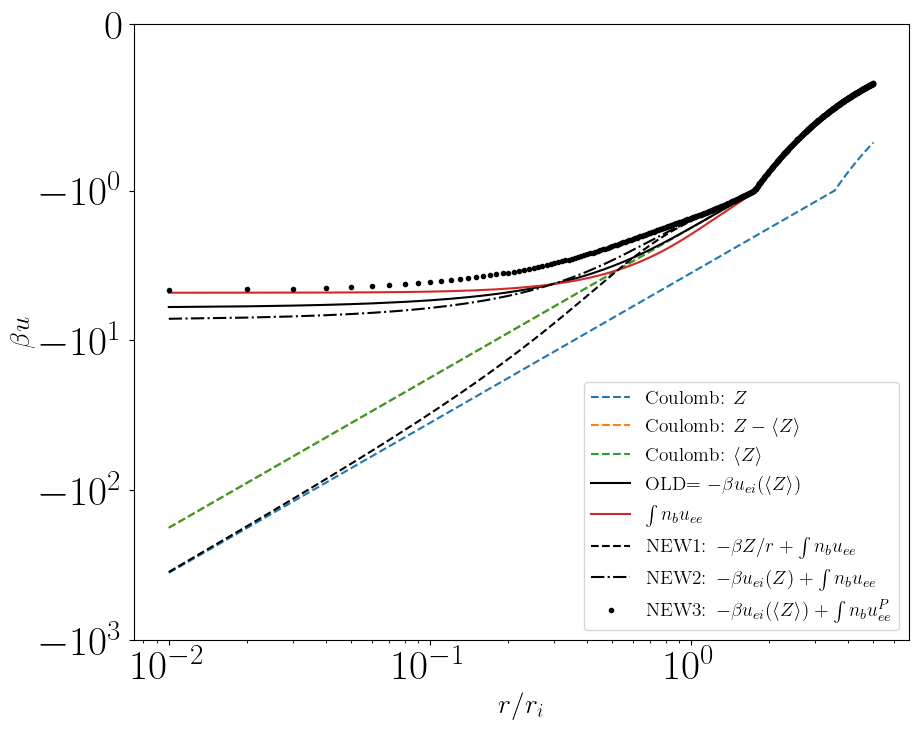

In [7]:
fig, ax = plt.subplots(figsize=(10,8))


ax.plot(atom.hnc.r_array, -1/atom.hnc.Temp_matrix[0,1] * Z/(atom.hnc.r_array*atom.qsp.ri),'--', label=r'Coulomb: $ Z$')
ax.plot(atom.hnc.r_array, -1/atom.hnc.Temp_matrix[0,1] * (Z-Zbar)/(atom.hnc.r_array*atom.qsp.ri),'--', label=r'Coulomb: $ Z-\langle Z \rangle$')
ax.plot(atom.hnc.r_array, -1/atom.hnc.Temp_matrix[0,1] * Zbar/(atom.hnc.r_array*atom.qsp.ri),'--', label=r'Coulomb: $\langle Z \rangle$')
ax.plot(atom.hnc.r_array, atom.hnc.βu_r_matrix[0,1], 'k-',label=r'OLD= $-\beta u_{ei}(\langle Z \rangle)$')
ax.plot(atom.hnc.r_array, -δβuei, label=r' $\int n_b u_{ee}$ ')
ax.plot(atom.hnc.r_array, -1/atom.hnc.Temp_matrix[0,1]* Z/(atom.hnc.r_array*atom.qsp.ri) + δβuei,'k--' , label=r' NEW1: $-\beta Z/r + \int n_b u_{ee}$ ')
ax.plot(atom.hnc.r_array,  Z/Zbar*atom.hnc.βu_r_matrix[0,1] + δβuei,'k-.' , label=r' NEW2: $-\beta u_{ei}(Z) + \int n_b u_{ee}$ ')
ax.plot(atom.hnc.r_array,  atom.hnc.βu_r_matrix[0,1] + δβuei_Pauli,'k.' , label=r' NEW3: $-\beta u_{ei}(\langle Z \rangle) + \int n_b u^P_{ee}$ ')

ax.legend(fontsize=14)
ax.set_yscale('symlog', linthresh=1)
ax.set_xscale('log')

ax.set_ylabel(r"$\beta u$", fontsize=20)
ax.set_xlabel(r"$r/r_i$", fontsize=20)

ax.set_ylim(-1e3,0e0)

In [8]:
atom = PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Z, find_βuee=True,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options= {'r_c':0.0},
             hnc_options= {'kappa_multiscale':10, 'R_max':5,'N_bins':500,'oz_method':'svt'},
             hnc_solve_options={'alpha_Picard':0.1})

atom_oz = PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Z, find_βuee=True,
             βu_options = {'add_bridge':False,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options= {'r_c':0.0,'which_Tij':'thermal'},
             hnc_options= {'kappa_multiscale':10, 'R_max':5,'N_bins':500,'oz_method':'standard'},
             hnc_solve_options={'alpha_Picard':0.1})

atom.hnc.βu_r_matrix[0,1] = atom.hnc.βu_r_matrix[0,1] + δβuei#_Pauli
atom.hnc.βu_r_matrix[1,0] = atom.hnc.βu_r_matrix[1,0] + δβuei#_Pauli
atom.hnc.set_βu_matrix(atom.hnc.βu_r_matrix)

atom_oz.hnc.βu_r_matrix[0,1] = atom_oz.hnc.βu_r_matrix[0,1] + δβuei
atom_oz.hnc.βu_r_matrix[1,0] = atom_oz.hnc.βu_r_matrix[1,0] + δβuei
atom_oz.hnc.set_βu_matrix(atom_oz.hnc.βu_r_matrix)

# Run them
atom.run_hnc()
atom_oz.run_hnc()
atom_oz.run_ocp_hnc()


Te_in_eV: 13.000
Ti_in_eV: 13.000
Te_in_eV: 13.000
Ti_in_eV: 13.000
0: Initial condition Total Error: 6.746e+00
Exiting status 1, reverting to best index so far: 1001
Final iter:1001, Total Error: 2.422e-08

Root Finder:  True The solution converged. final err: 3.716e-12
0: Initial condition Total Error: 6.760e+00
Exiting status 1, reverting to best index so far: 1001
Final iter:1001, Total Error: 2.464e-08

Root Finder:  True The solution converged. final err: 1.851e-14
0: Initial condition Total Error: 1.434e+01
Exiting status 0, reverting to best index so far: 957
Final iter:958, Total Error: 9.858e-09


In [ ]:

atom_2e = PLASMA_UD(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Z, Picard_max_err=1,find_βuee=True,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options= {'r_c':0.0,'which_Tij':'thermal'},
             hnc_options= {'kappa_multiscale':10, 'R_max':5,'N_bins':500,'oz_method':'standard'},
             hnc_solve_options={'alpha_Picard':0.1,'iters_to_wait':1000,'verbose':False,'iters_to_use':10})

atom_2e.hnc.βu_r_matrix[0,1] = atom_2e.hnc.βu_r_matrix[0,1] + δβuei#_Pauli
atom_2e.hnc.βu_r_matrix[1,0] = atom_2e.hnc.βu_r_matrix[1,0] + δβuei#_Pauli
atom_2e.hnc.βu_r_matrix[2,0] = atom_2e.hnc.βu_r_matrix[1,0] + δβuei#_Pauli
atom_2e.hnc.βu_r_matrix[0,2] = atom_2e.hnc.βu_r_matrix[1,0] + δβuei#_Pauli

atom_2e.run_hnc()


In [ ]:
# Bredow_CHNC = read_csv("/home/zach/plasma/datasets/RDFs/Be_12eV_1.24e23cc_CHNC_Bredow.txt" , delim_whitespace=True, header=0)
# Bredow_DFT = read_csv("/home/zach/plasma/datasets/RDFs/Be_12eV_1.24e23cc_DFT_Bredow.txt"   , delim_whitespace=True, header=0)
Bredow_CHNC = read_csv("/home/zach/plasma/datasets/RDFs/Be_13eV_3.676e23cc_CHNC_Bredow.txt", delim_whitespace=True, header=0)
Bredow_DFT = read_csv("/home/zach/plasma/datasets/RDFs/Be_13eV_3.676e23cc_DFT_Bredow.txt"  , delim_whitespace=True, header=0)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(atom.hnc.r_array*atom.qsp.ri, atom.hnc.h_r_matrix[0,0]+1,'--', label='my SVT CHNC')
ax.plot(atom_oz.hnc.r_array*atom_oz.qsp.ri, atom_oz.hnc.h_r_matrix[0,0]+1,'--', label='my OZ CHNC')
ax.plot(atom_oz.ocp_hnc.r_array*atom_oz.qsp.ri, atom_oz.ocp_hnc.h_r_matrix[0,0]+1,'-.', label='Only Ion')
ax.plot(atom_2e.hnc.r_array*atom_2e.qsp.ri, atom_2e.hnc.h_r_matrix[0,0]+1,'--', label='my Two e SVT')

ax.plot(Bredow_CHNC['r[aB]'], Bredow_CHNC['gii'], label="Bredow CHNC")
ax.plot(Bredow_DFT['r[aB]'], Bredow_DFT['gii'],'k-', label="Bredow DFT")
ax.set_xlim(0,6)
ax.set_ylabel(r'$g_{ii}$',fontsize=20)
ax.set_xlabel(r'$r$ [A.U.]',fontsize=20)
ax.tick_params(labelsize=20)

ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(atom.hnc.r_array*atom.qsp.ri, atom.hnc.h_r_matrix[0,1]+1,'--', label='my SVT CHNC')
ax.plot(atom_oz.hnc.r_array*atom_oz.qsp.ri, atom_oz.hnc.h_r_matrix[0,1]+1,'--', label='my OZ CHNC')
ax.plot(AA_r_AU_full/atom.qsp.ri, AA_nb_AU_full)


ax.set_xlim(0,1)
ax.set_ylabel(r'$g_{ei} r^2$',fontsize=20)
ax.set_xlabel(r'$r$ [A.U.]',fontsize=20)
ax.tick_params(labelsize=20)

ax.legend()

## EOS and Transport

In [ ]:
from scipy.integrate import simpson

def get_ηBG(plasma):
    plasma.hnc.invert_HNC_OZ([1])
    fBG = -1
    n_AU = n_from_rs(plasma.qsp.ri)
    r_array = plasma.hnc.r_array*plasma.qsp.ri
    gii = plasma.hnc.h_r_matrix[0,0]+1
    dφdr = plasma.qsp.Ti*np.gradient(plasma.hnc.βueff_r_matrix[0,0], r_array)

    integrand = r_array**4 * gii * dφdr
    ##
    fig, ax = plt.subplots()
    ax.plot(r_array, dφdr*r_array**4)
    ###
    integral = simpson(integrand, x=r_array)
    η = fBG* 2*π/15 * (plasma.qsp.βi*plasma.qsp.m_i)**0.5*n_AU**2*integral
    return η

η_SI = get_ηBG(atom)*AU_to_Pa*AU_to_s # Pa s = kg m^-1 s^-1 
print(f"SI: η = {η_SI:0.3e} [kg m^-1 s^-1] (or [Pa s])")
η_cgs = η_SI * 1000/100 # g cm^-1 s^-1
print(f"CGS: η = {η_cgs:0.3e} [g cm^-1 s^-1]")

In [ ]:
def excess_pressure_matrix(plasma):

    r = plasma.r_array[np.newaxis,np.newaxis,:]
    dr = plasma.del_r

    u_matrix = plasma.βu_r_matrix*plasma.Temp_matrix[:,:,np.newaxis]
    du_dr_matrix = np.gradient(u_matrix, plasma.r_array, axis=2)

    g_matrix = plasma.h_r_matrix+1
    rho_matrix = plasma.rho[:,np.newaxis]*plasma.rho[np.newaxis,:]

    integrand_matrix = 2*π/3*rho_matrix[:,:,np.newaxis]*du_dr_matrix*g_matrix*r**3*dr
    P_ex_matrix = -np.sum(integrand_matrix,axis=2)
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(plasma.r_array, np.sum(integrand_matrix,axis=(0,1)))
    return P_ex_matrix

excess_pressure_matrix(atom.hnc)
